# Import library and Data Analysis






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization, Input
from keras.optimizers import Adam
from keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import mixed_precision
mixed_precision.set_global_policy('float32')


print(tf.__version__)

2.15.0


Loading dataset

In [ ]:
# Define dataset paths
dataset = {
            "train_data" : "/content/drive/MyDrive/Original data/data original/train",
             "valid_data" : "/content/drive/MyDrive/Original data/data original/valid",
             "test_data" : "/content/drive/MyDrive/Original data/data original/test"
}


all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

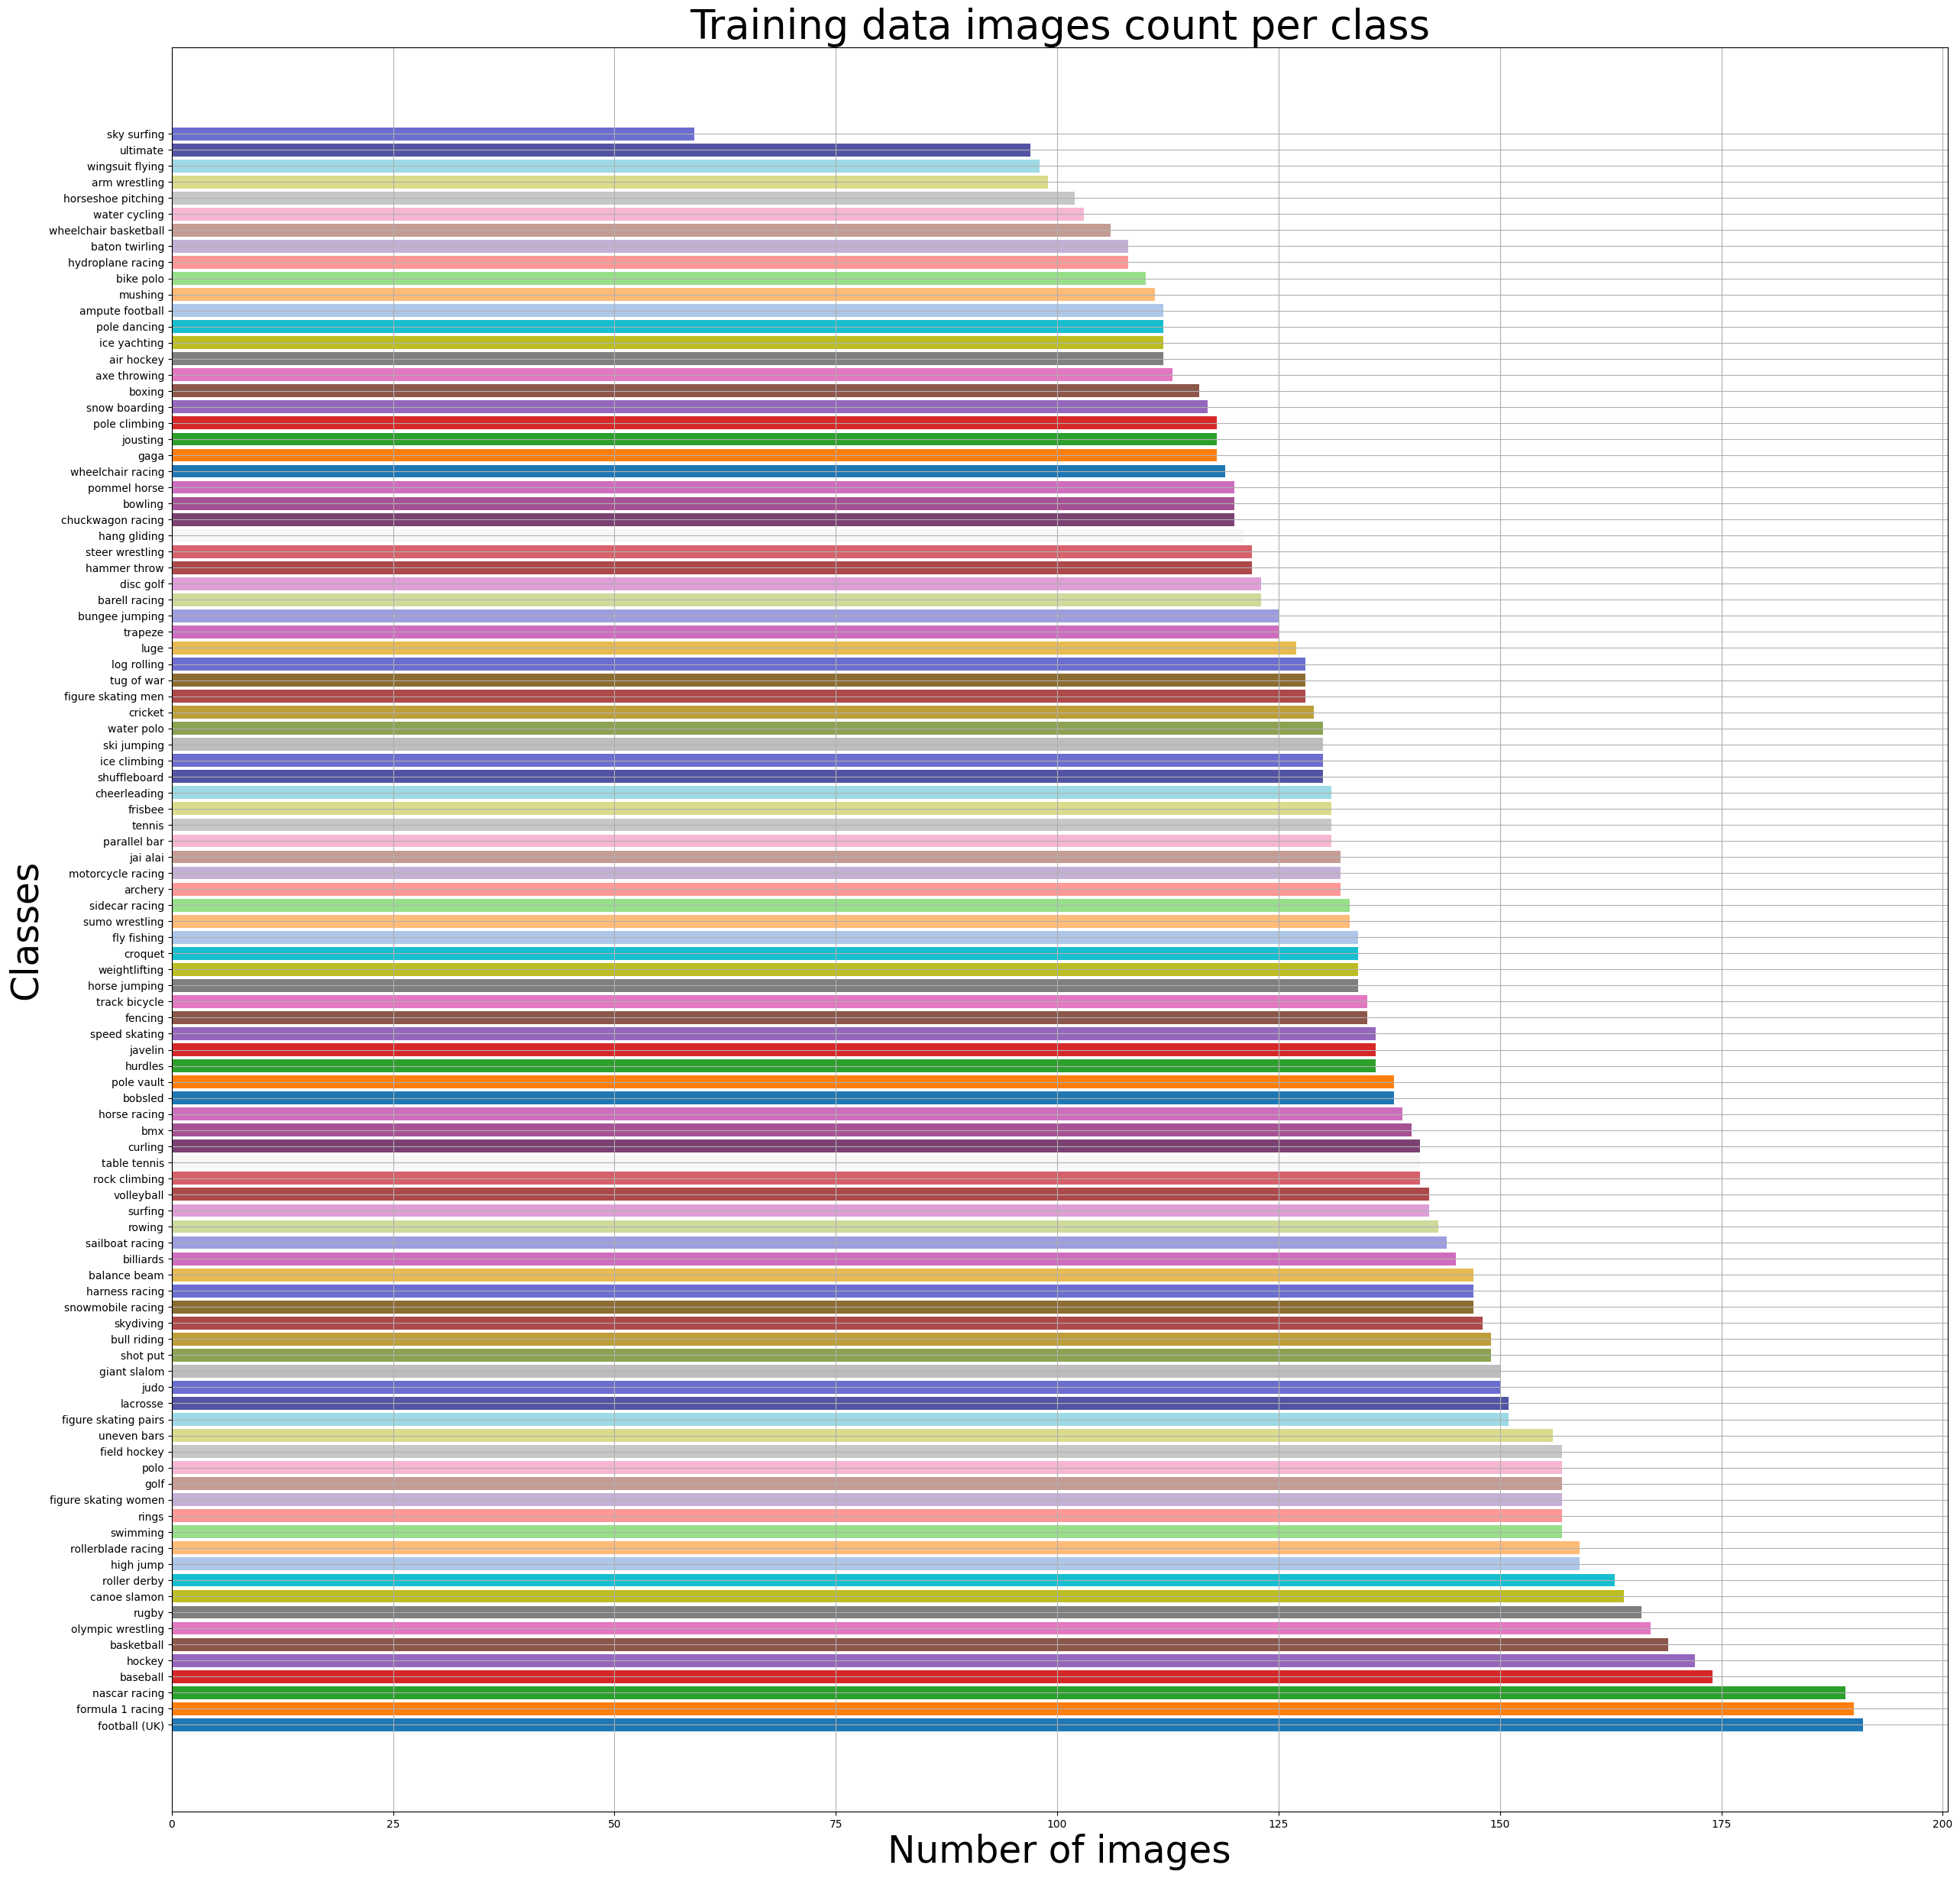

In [ ]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


In [ ]:
train_df.sample(n=15, random_state=1)

imgpath             labels  \
3449   /content/drive/MyDrive/Original data/data orig...             rowing   
5802   /content/drive/MyDrive/Original data/data orig...  motorcycle racing   
2979   /content/drive/MyDrive/Original data/data orig...              rugby   
1034   /content/drive/MyDrive/Original data/data orig...        uneven bars   
479    /content/drive/MyDrive/Original data/data orig...         water polo   
9143   /content/drive/MyDrive/Original data/data orig...   formula 1 racing   
4737   /content/drive/MyDrive/Original data/data orig...       pole dancing   
6433   /content/drive/MyDrive/Original data/data orig...           jousting   
35     /content/drive/MyDrive/Original data/data orig...  wheelchair racing   
11522  /content/drive/MyDrive/Original data/data orig...             boxing   
9122   /content/drive/MyDrive/Original data/data orig...   formula 1 racing   
3709   /content/drive/MyDrive/Original data/data orig...     sidecar racing   
11490  /content/drive/MyDrive/Original data/data orig...             boxing   
4461   /content/drive/MyDrive/Original data/data orig...      rock climbing   
11966  /content/drive/MyDrive/Original data/data orig...          bike polo   

       encoded_labels  
3449               70  
5802               56  
2979               71  
1034               92  
479                95  
9143               32  
4737               62  
6433               51  
35                 98  
11522              15  
9122               32  
3709               75  
11490              15  
4461               67  
11966              10

In [ ]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath             labels
0  /content/drive/MyDrive/Original data/data orig...  wheelchair racing
1  /content/drive/MyDrive/Original data/data orig...  wheelchair racing
2  /content/drive/MyDrive/Original data/data orig...  wheelchair racing
3  /content/drive/MyDrive/Original data/data orig...  wheelchair racing
4  /content/drive/MyDrive/Original data/data orig...  wheelchair racing
(13493, 3)
--------Validation----------
                                             imgpath                 labels
0  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
1  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
2  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
3  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
4  /content/drive/MyDrive/Original data/data orig...  wheelchair basketball
(500, 3)
----------Test--------------
     

Show sample from data

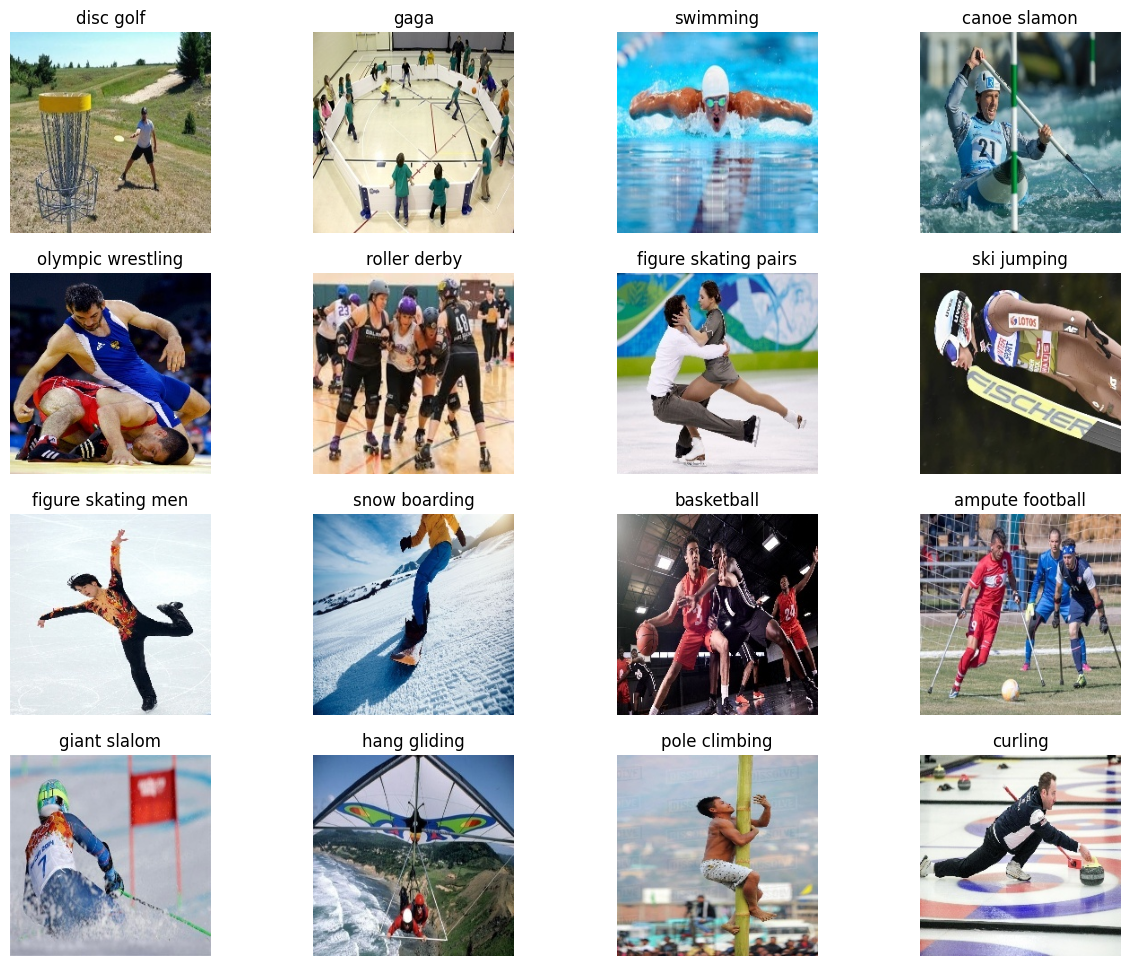

In [ ]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

#EfficientNet B0

In [ ]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_19 (Dense)            (None, 350)               448350    
                                                                 
 activation_193 (Activation  (None, 350)               0         
 )                                                               
                                                          

Training: Transfer learning

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save('/content/drive/MyDrive/Thesis /data_thesis/EfficientNetB0.h5')

Epoch 1/50
1350/1350 [==============================] - 53s 34ms/step - loss: 1.7867 - accuracy: 0.5782 - val_loss: 0.5288 - val_accuracy: 0.8640 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 47s 35ms/step - loss: 0.8310 - accuracy: 0.7850 - val_loss: 0.3834 - val_accuracy: 0.8840 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 49s 36ms/step - loss: 0.6567 - accuracy: 0.8256 - val_loss: 0.2581 - val_accuracy: 0.9320 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 48s 35ms/step - loss: 0.5776 - accuracy: 0.8436 - val_loss: 0.2677 - val_accuracy: 0.9180 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 47s 35ms/step - loss: 0.5148 - accuracy: 0.8606 - val_loss: 0.3301 - val_accuracy: 0.9060 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.4242 - accuracy: 0.8830 - val_loss: 0.2100 - val_accuracy: 0.9380 - lr: 1.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

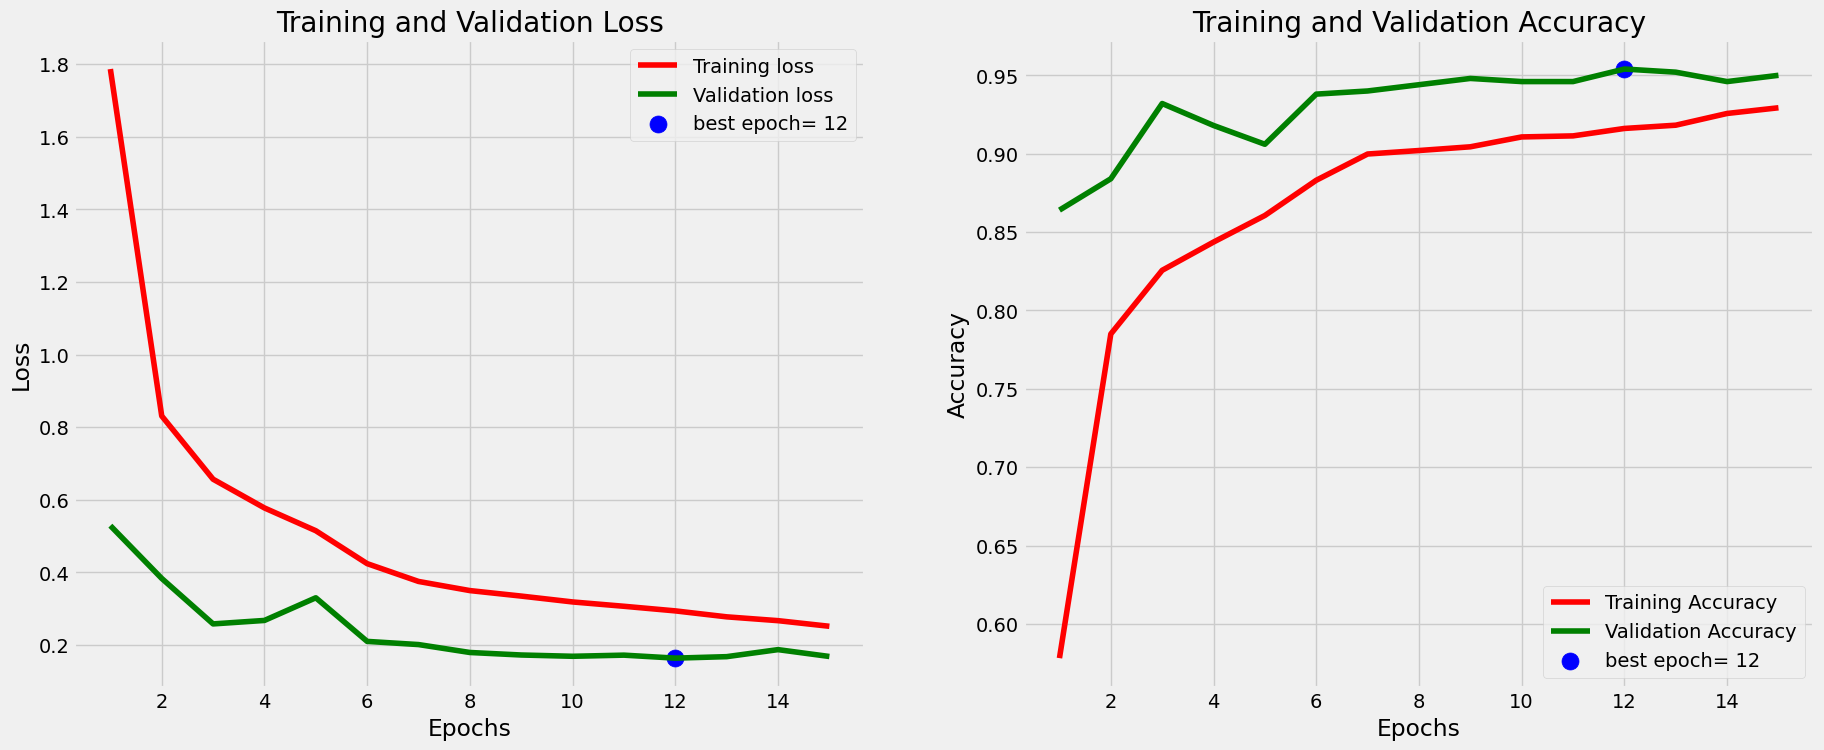

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


Model Evaluate

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.13204
Test Accuracy: 96.00%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

50/50 [==============================] - 3s 31ms/step
F1 Score: 0.9577568542568542
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       0.83      1.00      0.91         5
             baseball       1.00      1.00      1.00         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       0.80      0.80      0.80         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00  

#VGG16

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_vgg16 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_vgg16 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_vgg16 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
from keras.applications import VGG16
# Load and modify the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

In [ ]:
from keras.layers import GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
num_classes = len(set(train_images_vgg16.classes))
# Define data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomContrast(0.1),
], name='data_augmentation')

# Modify the model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Set training=False for batch norm layers
x = GlobalAveragePooling2D()(x)
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model (Transfer learning)
history_vgg16 = model.fit(
    train_images_vgg16,
    steps_per_epoch=len(train_images_vgg16),
    validation_data=val_images_vgg16,
    validation_steps=len(val_images_vgg16),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis/data_thesis/vgg16.h5')


Epoch 1/50
1350/1350 [==============================] - 80s 58ms/step - loss: 2.7837 - accuracy: 0.3450 - val_loss: 1.9901 - val_accuracy: 0.5880 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 77s 57ms/step - loss: 1.6951 - accuracy: 0.5625 - val_loss: 1.3072 - val_accuracy: 0.7020 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 77s 57ms/step - loss: 1.4599 - accuracy: 0.6124 - val_loss: 1.2758 - val_accuracy: 0.7280 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 77s 57ms/step - loss: 1.3173 - accuracy: 0.6495 - val_loss: 1.0760 - val_accuracy: 0.7600 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 77s 57ms/step - loss: 1.2254 - accuracy: 0.6672 - val_loss: 1.1721 - val_accuracy: 0.7100 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 77s 57ms/step - loss: 1.1814 - accuracy: 0.6790 - val_loss: 1.3482 - val_accuracy: 0.7260 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

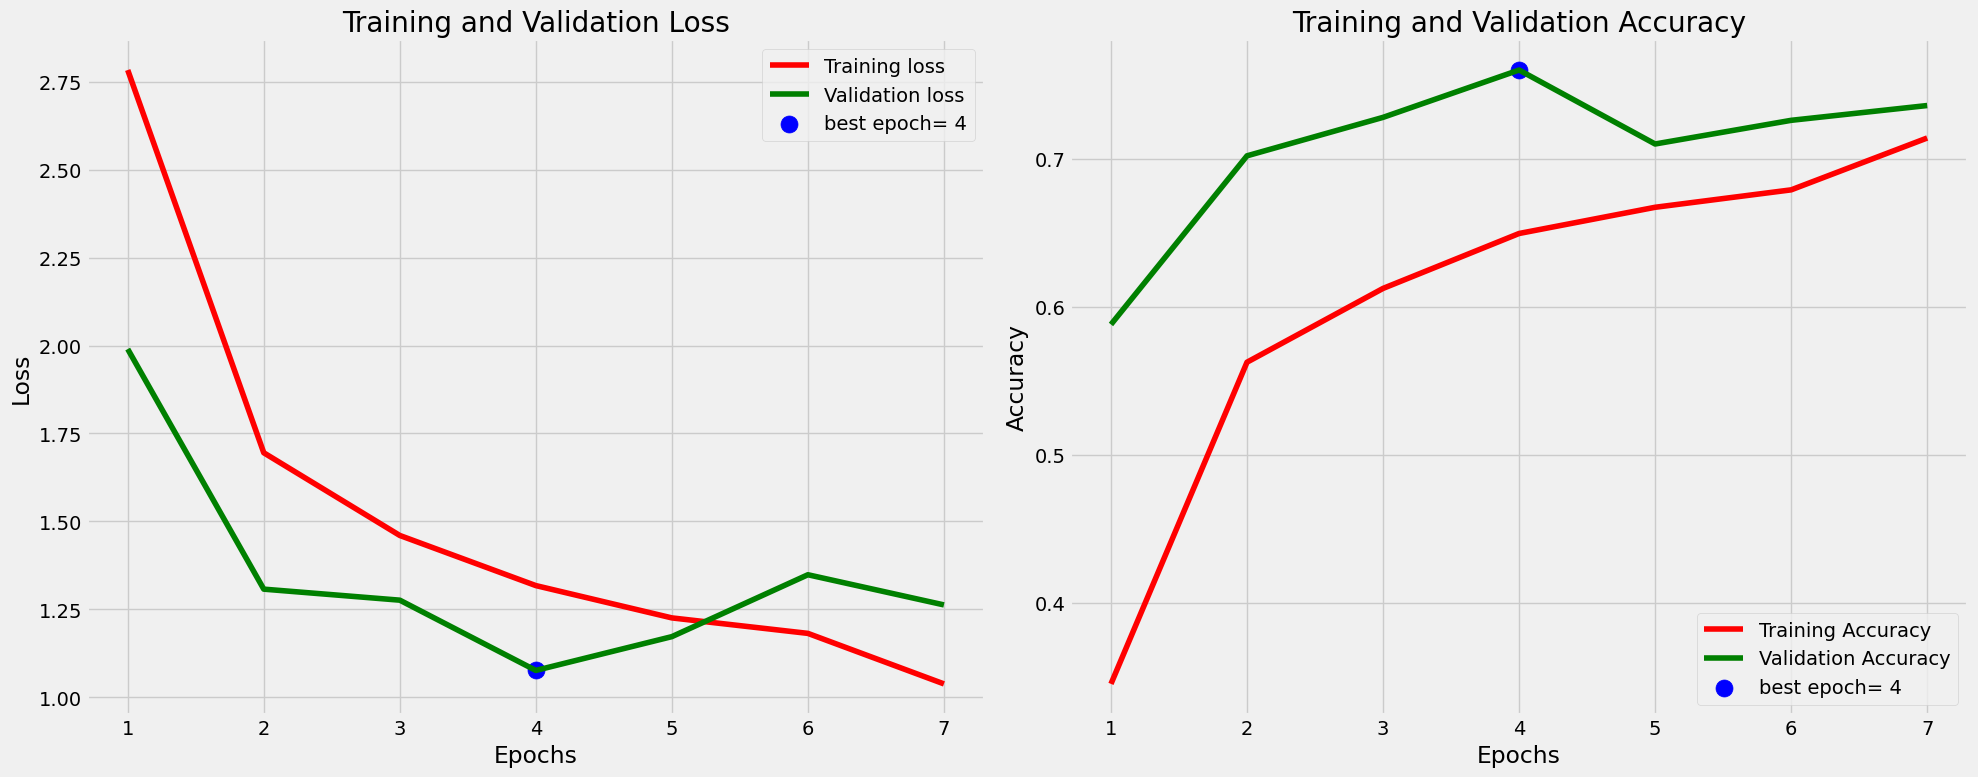

In [ ]:
# Corrected variable assignments
tr_acc = history_vgg16.history['accuracy']
tr_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model evaluate

In [ ]:
results = model.evaluate(test_images_vgg16, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.78659
Test Accuracy: 81.40%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_vgg16.classes
y_pred = np.argmax(model.predict(test_images_vgg16), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_vgg16.class_indices.keys()))

50/50 [==============================] - 3s 51ms/step
F1 Score: 0.8078963813963813
                       precision    recall  f1-score   support

           air hockey       1.00      0.60      0.75         5
      ampute football       0.83      1.00      0.91         5
              archery       0.50      0.80      0.62         5
        arm wrestling       0.83      1.00      0.91         5
         axe throwing       0.71      1.00      0.83         5
         balance beam       0.75      0.60      0.67         5
        barell racing       0.56      1.00      0.71         5
             baseball       0.60      0.60      0.60         5
           basketball       0.75      0.60      0.67         5
       baton twirling       0.75      0.60      0.67         5
            bike polo       0.62      1.00      0.77         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       0.80  

#ResNet50

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_resnet50 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_resnet50 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_resnet50 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
from keras.applications import ResNet50
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
num_classes = len(set(train_images_resnet50.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Load pre-trained ResNet50 model
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

inputs_resnet50 = layers.Input(shape=(224, 224, 3), name='inputLayer')
x_resnet50 = augment(inputs_resnet50)
pretrain_out_resnet50 = pretrained_model_resnet50(x_resnet50, training=False)
x_resnet50 = layers.Dense(350, activation="relu")(pretrain_out_resnet50)
x_resnet50 = layers.BatchNormalization()(x_resnet50)
x_resnet50 = layers.Dropout(0.25)(x_resnet50)
x_resnet50 = layers.Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_resnet50)

model_resnet50 = Model(inputs=inputs_resnet50, outputs=x_resnet50)

model_resnet50.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_resnet50.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 350)               717150    
                                                                 
 batch_normalization_1 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 350)               0   

Transfer learning

In [ ]:
history_resnet50 = model_resnet50.fit(
    train_images_resnet50,
    steps_per_epoch=len(train_images_resnet50),
    validation_data=val_images_resnet50,
    validation_steps=len(val_images_resnet50),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet50.save_weights('/content/drive/MyDrive/Thesis /data_thesis/Resnet50.h5')

Epoch 1/50
1350/1350 [==============================] - 66s 45ms/step - loss: 2.3325 - accuracy: 0.4536 - val_loss: 0.9669 - val_accuracy: 0.7040 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 58s 43ms/step - loss: 1.3301 - accuracy: 0.6605 - val_loss: 0.6580 - val_accuracy: 0.7840 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 58s 43ms/step - loss: 1.1176 - accuracy: 0.7026 - val_loss: 0.5695 - val_accuracy: 0.8180 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 58s 43ms/step - loss: 1.0010 - accuracy: 0.7310 - val_loss: 0.5648 - val_accuracy: 0.8180 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 58s 43ms/step - loss: 0.9242 - accuracy: 0.7462 - val_loss: 0.6205 - val_accuracy: 0.7900 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 58s 43ms/step - loss: 0.8714 - accuracy: 0.7567 - val_loss: 0.5478 - val_accuracy: 0.8240 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

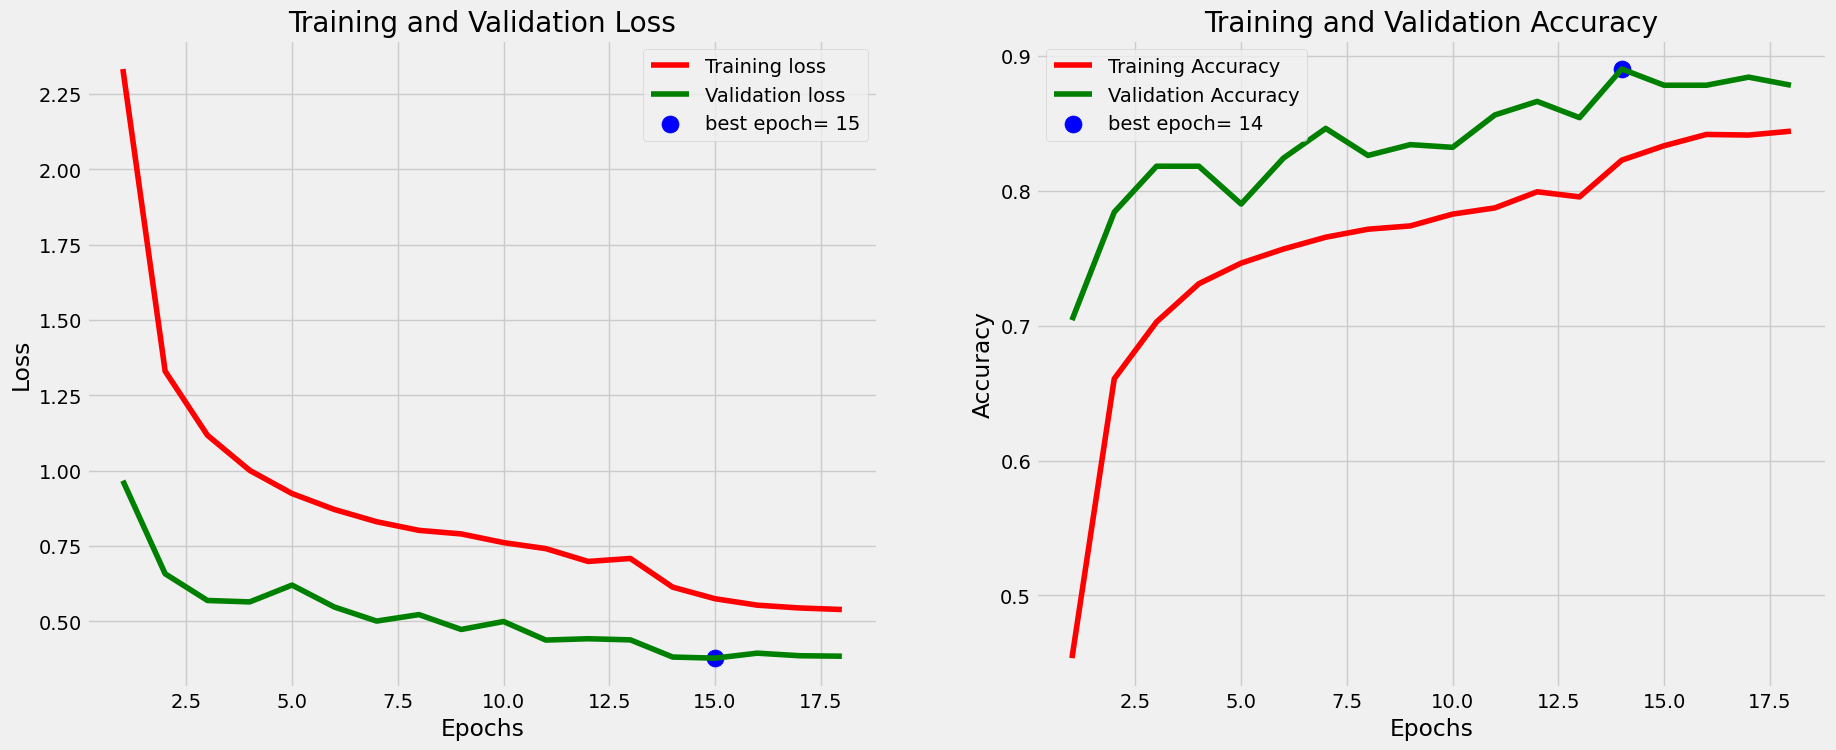

In [ ]:
# Define needed variables
tr_acc = history_resnet50.history['accuracy']
tr_loss = history_resnet50.history['loss']
val_acc = history_resnet50.history['val_accuracy']
val_loss = history_resnet50.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

  model evaluate

In [ ]:
results_resnet50 = model_resnet50.evaluate(test_images_resnet50, verbose=0)
print("ResNet50 Model - Test Loss: {:.5f}".format(results_resnet50[0]))
print("ResNet50 Model - Test Accuracy: {:.2f}%".format(results_resnet50[1] * 100))

ResNet50 Model - Test Loss: 0.31331
ResNet50 Model - Test Accuracy: 90.00%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_resnet50.classes
y_pred = np.argmax(model_resnet50.predict(test_images_resnet50), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_resnet50.class_indices.keys()))

50/50 [==============================] - 3s 37ms/step
F1 Score: 0.8943552558552558
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.50      0.80      0.62         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       0.62      1.00      0.77         5
        barell racing       0.83      1.00      0.91         5
             baseball       1.00      0.60      0.75         5
           basketball       0.80      0.80      0.80         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       0.80      0.80      0.80         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.40      0.57         5
              bobsled       0.80  

#MobileNet V3 Large

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_mobilenet = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_mobilenet = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_mobilenet = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
from keras.applications import MobileNetV3Large

pretrained_model_mobilenetv3 = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_mobilenetv3.layers:
    layer.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import GlobalAveragePooling2D
num_classes = len(set(train_images_mobilenet.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Building the model
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
x = pretrained_model_mobilenetv3(x, training=False)


# Removed GlobalAveragePooling2D as the pretrained model already includes pooling
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)


# Compile the model
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 dense_8 (Dense)             (None, 350)               336350    
                                                                 
 batch_normalization_4 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                           

Transfer learning

In [ ]:
# Training the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis/data_thesis/MobileNetV3Large.h5')


Epoch 1/50
1350/1350 [==============================] - 54s 35ms/step - loss: 2.7982 - accuracy: 0.3166 - val_loss: 1.3341 - val_accuracy: 0.5940 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 47s 35ms/step - loss: 1.6308 - accuracy: 0.5576 - val_loss: 0.8757 - val_accuracy: 0.7300 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 46s 34ms/step - loss: 1.3258 - accuracy: 0.6364 - val_loss: 0.6369 - val_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 47s 35ms/step - loss: 1.1477 - accuracy: 0.6858 - val_loss: 0.6423 - val_accuracy: 0.8100 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 47s 34ms/step - loss: 1.0681 - accuracy: 0.7078 - val_loss: 0.5737 - val_accuracy: 0.8160 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 46s 34ms/step - loss: 0.9654 - accuracy: 0.7365 - val_loss: 0.4776 - val_accuracy: 0.8640 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

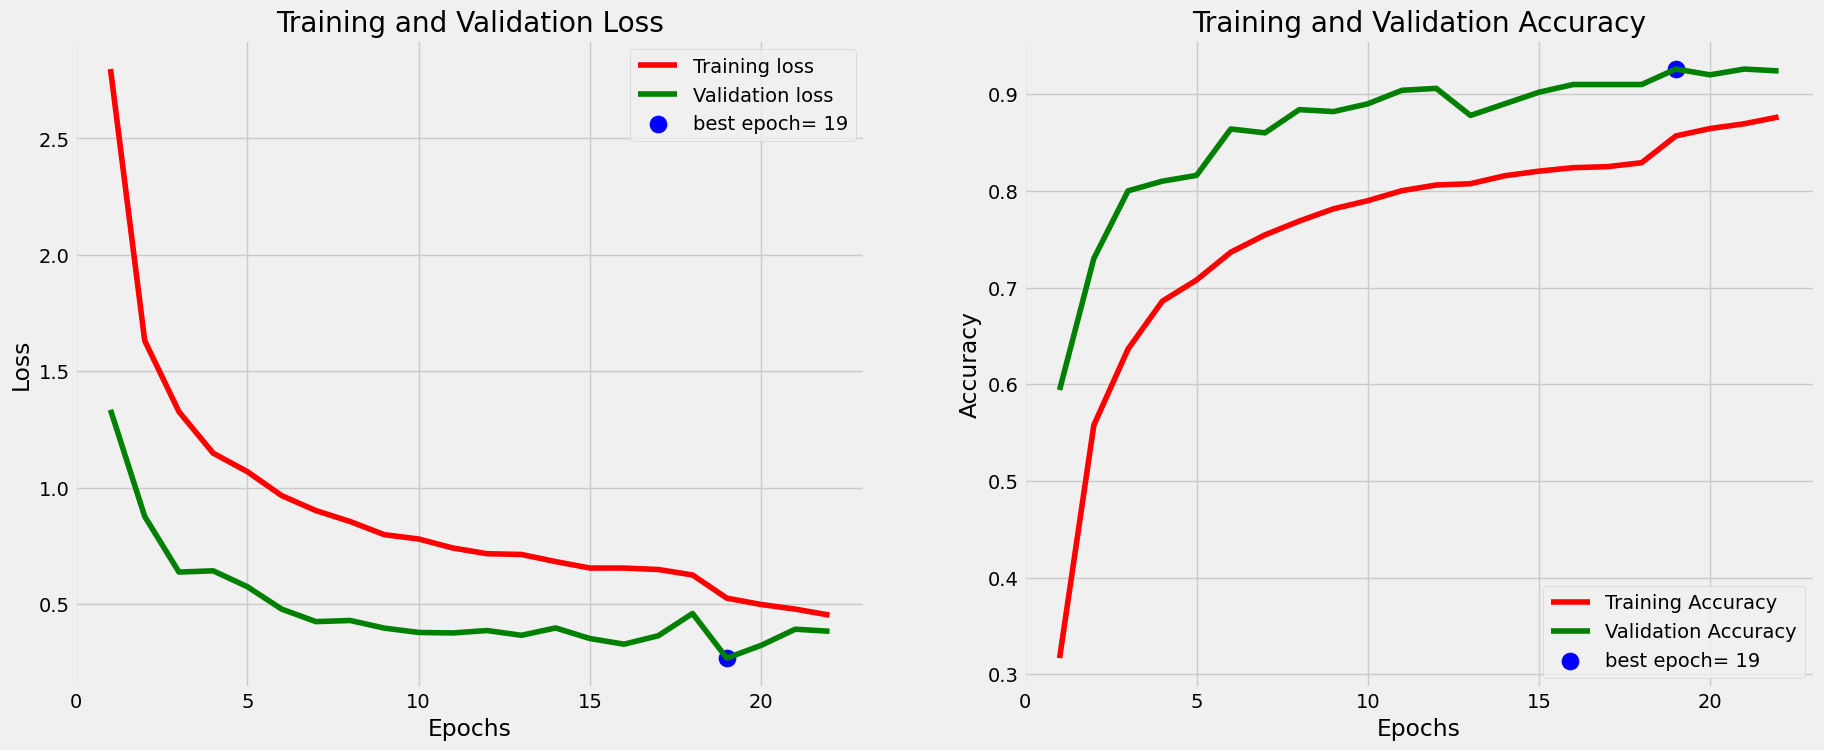

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

model evaluate

In [ ]:
results_mobilenet = model.evaluate(test_images_mobilenet, verbose=0)
print("MobileNet Model - Test Loss: {:.5f}".format(results_mobilenet[0]))
print("MobileNet Model - Test Accuracy: {:.2f}%".format(results_mobilenet[1] * 100))

MobileNet Model - Test Loss: 0.24741
MobileNet Model - Test Accuracy: 93.40%


F1 Score / Recall / Precision


In [ ]:
y_true = test_images_mobilenet.classes
y_pred = np.argmax(model.predict(test_images_mobilenet), axis=1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_mobilenet.class_indices.keys()))

50/50 [==============================] - 3s 32ms/step
F1 Score: 0.9312626262626261
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       0.83      1.00      0.91         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      1.00      1.00         5
           basketball       0.83      1.00      0.91         5
       baton twirling       0.83      1.00      0.91         5
            bike polo       1.00      0.80      0.89         5
            billiards       1.00      0.80      0.89         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00  

#Inception V3

In [ ]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 13492 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
from keras.applications import InceptionV3
# Load the pretrained model
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,  # We don't need the pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
from keras.applications.inception_v3 import preprocess_input

#generator = ImageDataGenerator(preprocessing_function=preprocess_input)

num_classes = len(set(train_images_inception_v3.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Define input shape and create input layer
inputs_inception_v3 = Input(shape=(224, 224, 3), name='inputLayer')
x_inception = augment(inputs_inception_v3)

# Load pre-trained InceptionV3 model
pretrained_model_inceptionv3 = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrain_out_inception = pretrained_model_inceptionv3(x_inception, training=False)

# Add classification layers on top of InceptionV3
x_inception = Dense(350, activation='relu')(pretrain_out_inception)
x_inception = BatchNormalization()(x_inception)
x_inception = Dropout(0.25)(x_inception)
x_inception = Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_inception)

model_inception_v3 = Model(inputs=inputs_inception_v3, outputs=x_inception)

# Freeze the layers of the InceptionV3 model
for layer in pretrained_model_inceptionv3.layers:
    layer.trainable = False

model_inception_v3.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model_inception_v3.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_12 (Dense)            (None, 350)               717150    
                                                                 
 batch_normalization_194 (B  (None, 350)               1400      
 atchNormalization)                                              
                                                                 
 dropout_6 (Dropout)         (None, 350)               0   

Transfer learning

In [ ]:
history_inception_v3 = model_inception_v3.fit(
    train_images_inception_v3,
    steps_per_epoch=len(train_images_inception_v3),
    validation_data=val_images_inception_v3,
    validation_steps=len(val_images_inception_v3),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_inception_v3.save('/content/drive/MyDrive/Thesis /data_thesis/InceptionV3.h5')

Epoch 1/50
1350/1350 [==============================] - 58s 38ms/step - loss: 2.8295 - accuracy: 0.3394 - val_loss: 1.6210 - val_accuracy: 0.5480 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - 49s 37ms/step - loss: 2.0350 - accuracy: 0.4928 - val_loss: 1.2126 - val_accuracy: 0.6620 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - 50s 37ms/step - loss: 1.8637 - accuracy: 0.5245 - val_loss: 1.1554 - val_accuracy: 0.6740 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] - 48s 35ms/step - loss: 1.7557 - accuracy: 0.5448 - val_loss: 2.3054 - val_accuracy: 0.4160 - lr: 5.0000e-04
Epoch 5/50
1350/1350 [==============================] - 49s 36ms/step - loss: 1.6955 - accuracy: 0.5568 - val_loss: 0.9936 - val_accuracy: 0.7180 - lr: 5.0000e-04
Epoch 6/50
1350/1350 [==============================] - 49s 36ms/step - loss: 1.6644 - accuracy: 0.5642 - val_loss: 0.9687 - val_accuracy: 0.7040 - lr: 5.0000e-04
Epoch 7/50
1350/1350 [

Display model performance

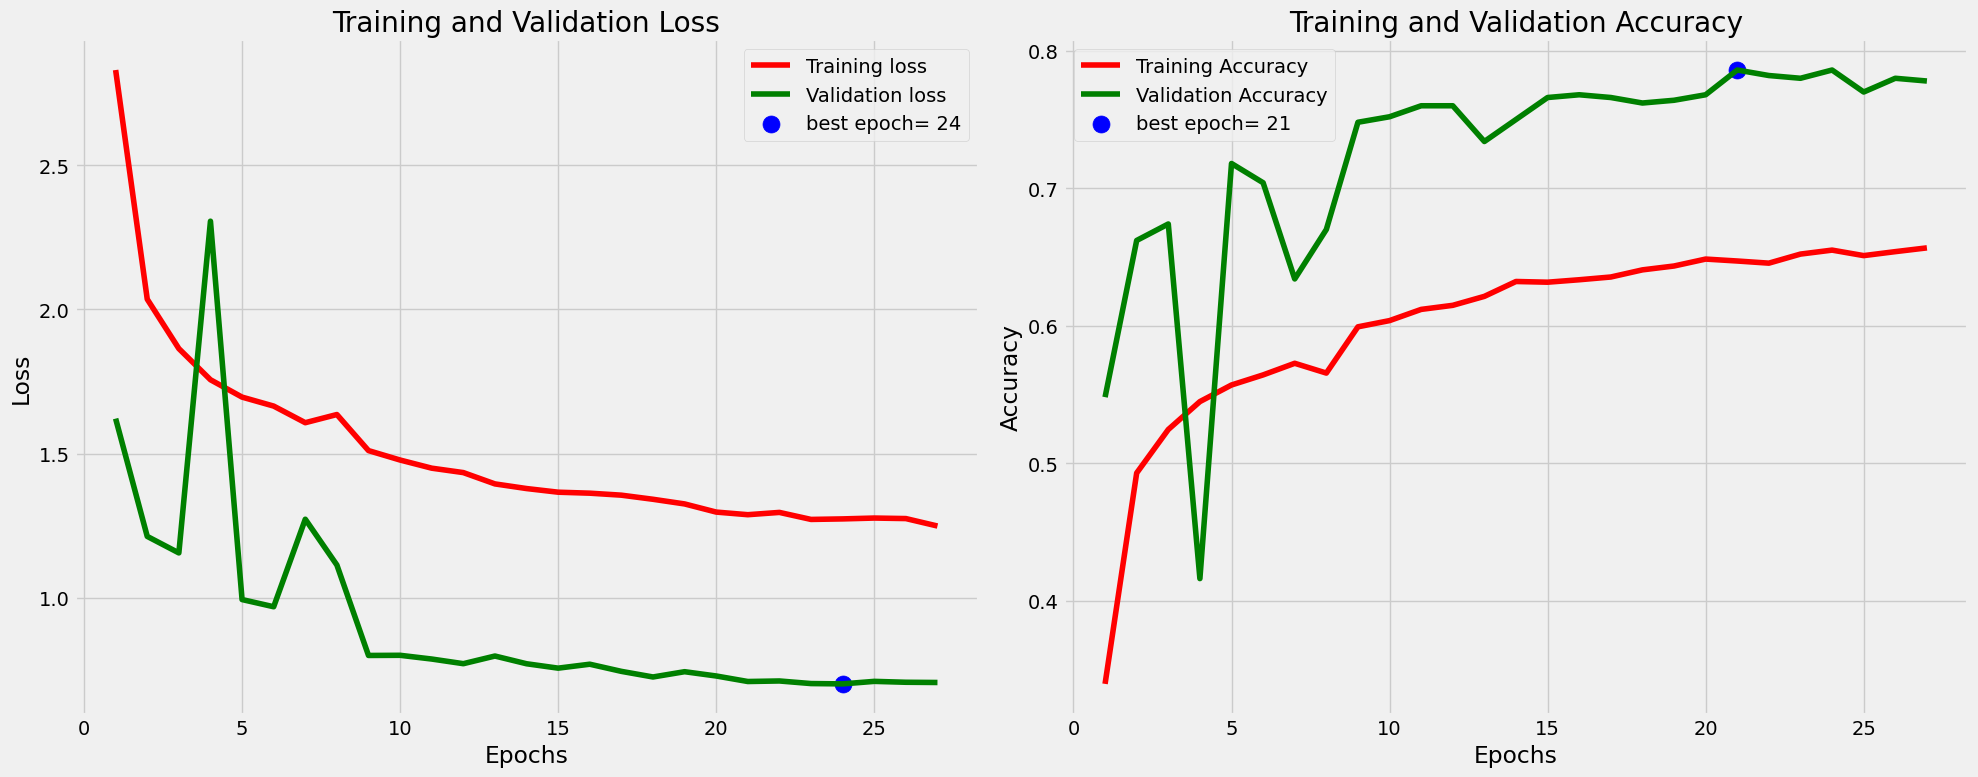

In [ ]:
# Define needed variables
tr_acc = history_inception_v3.history['accuracy']
tr_loss = history_inception_v3.history['loss']
val_acc = history_inception_v3.history['val_accuracy']
val_loss = history_inception_v3.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model Evaluate

In [ ]:
results = model_inception_v3.evaluate(test_images_inception_v3, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.60990
Test Accuracy: 80.40%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_inception_v3.classes
y_pred = np.argmax(model_inception_v3.predict(test_images_inception_v3), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_inception_v3.class_indices.keys()))

50/50 [==============================] - 3s 33ms/step
F1 Score: 0.7978165853754088
                       precision    recall  f1-score   support

           air hockey       1.00      0.40      0.57         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.71      1.00      0.83         5
        barell racing       0.42      1.00      0.59         5
             baseball       0.67      0.80      0.73         5
           basketball       0.75      0.60      0.67         5
       baton twirling       0.62      1.00      0.77         5
            bike polo       0.50      1.00      0.67         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.40      0.57         5
              bobsled       1.00  

#COMPARISON

In [ ]:
data = {
    'Model': ['ResNet50', 'VGG16', 'MobileNetV3 Large', 'EfficientNetB0', 'InceptionV3'],
    'Accuracy': ["90 %", "81.4 %", "93.4 %", "96 %", "80 %"],
    'F1 Score': [0.89 , 0.8, 0.93, 0.95, 0.79 ]
}

df = pd.DataFrame(data)

# Sort the DataFrame by 'Accuracy' in descending order
df = df.sort_values(by='Accuracy', ascending = False)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the ranked table
print(df)

               Model Accuracy  F1 Score
0     EfficientNetB0     96 %      0.95
1  MobileNetV3 Large   93.4 %      0.93
2           ResNet50     90 %      0.89
3              VGG16   81.4 %      0.80
4        InceptionV3     80 %      0.79


# Best model is EfficientNet B0

Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

55/55 [==============================] - 2s 34ms/step


Image Index  Test Labels     Test Classes  Prediction Labels  \
0            0          109  wingsuit flying                109   
1            1          109  wingsuit flying                109   
2            2          109  wingsuit flying                109   
3            3          109  wingsuit flying                109   
4            4          109  wingsuit flying                109   
5            5           99          trapeze                 32   
6            6           99          trapeze                 99   
7            7           99          trapeze                 69   

     Prediction Classes                                               Path  \
0       wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
1       wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
2       wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
3       wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
4       wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
5  figure skating women  /content/drive/MyDrive/Thesis /data_thesis/tes...   
6               trapeze  /content/drive/MyDrive/Thesis /data_thesis/tes...   
7            pole vault  /content/drive/MyDrive/Thesis /data_thesis/tes...   

   Prediction Probability  
0                0.999889  
1                0.974424  
2                0.979933  
3                0.999468  
4                0.914497  
5                0.363581  
6                0.456192  
7                0.691210

Print the most confident errors

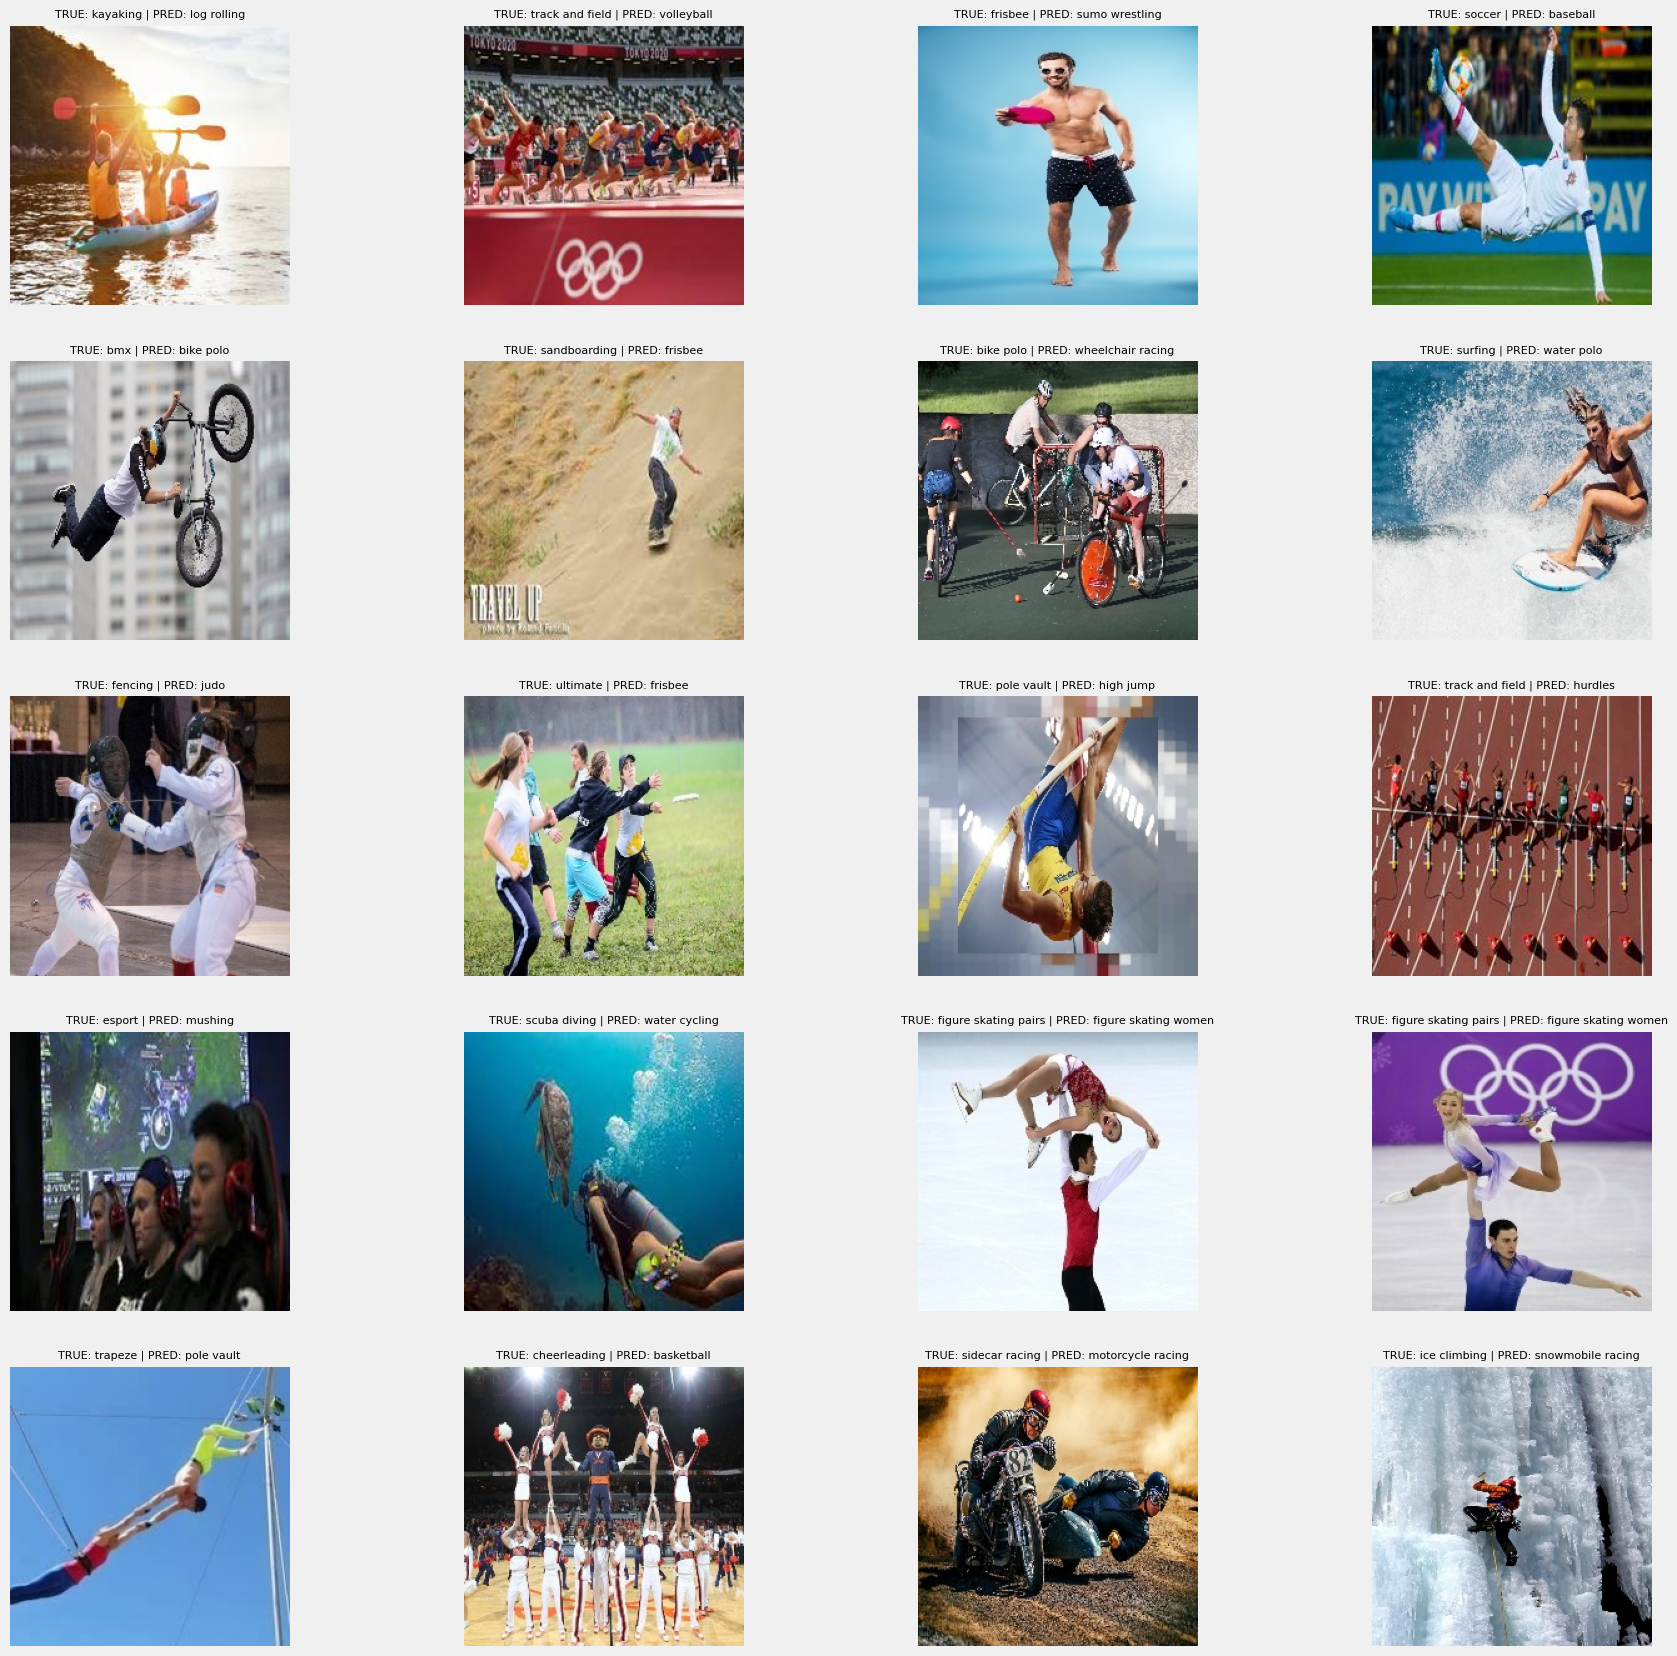

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Confusion Matrics and Classification Report

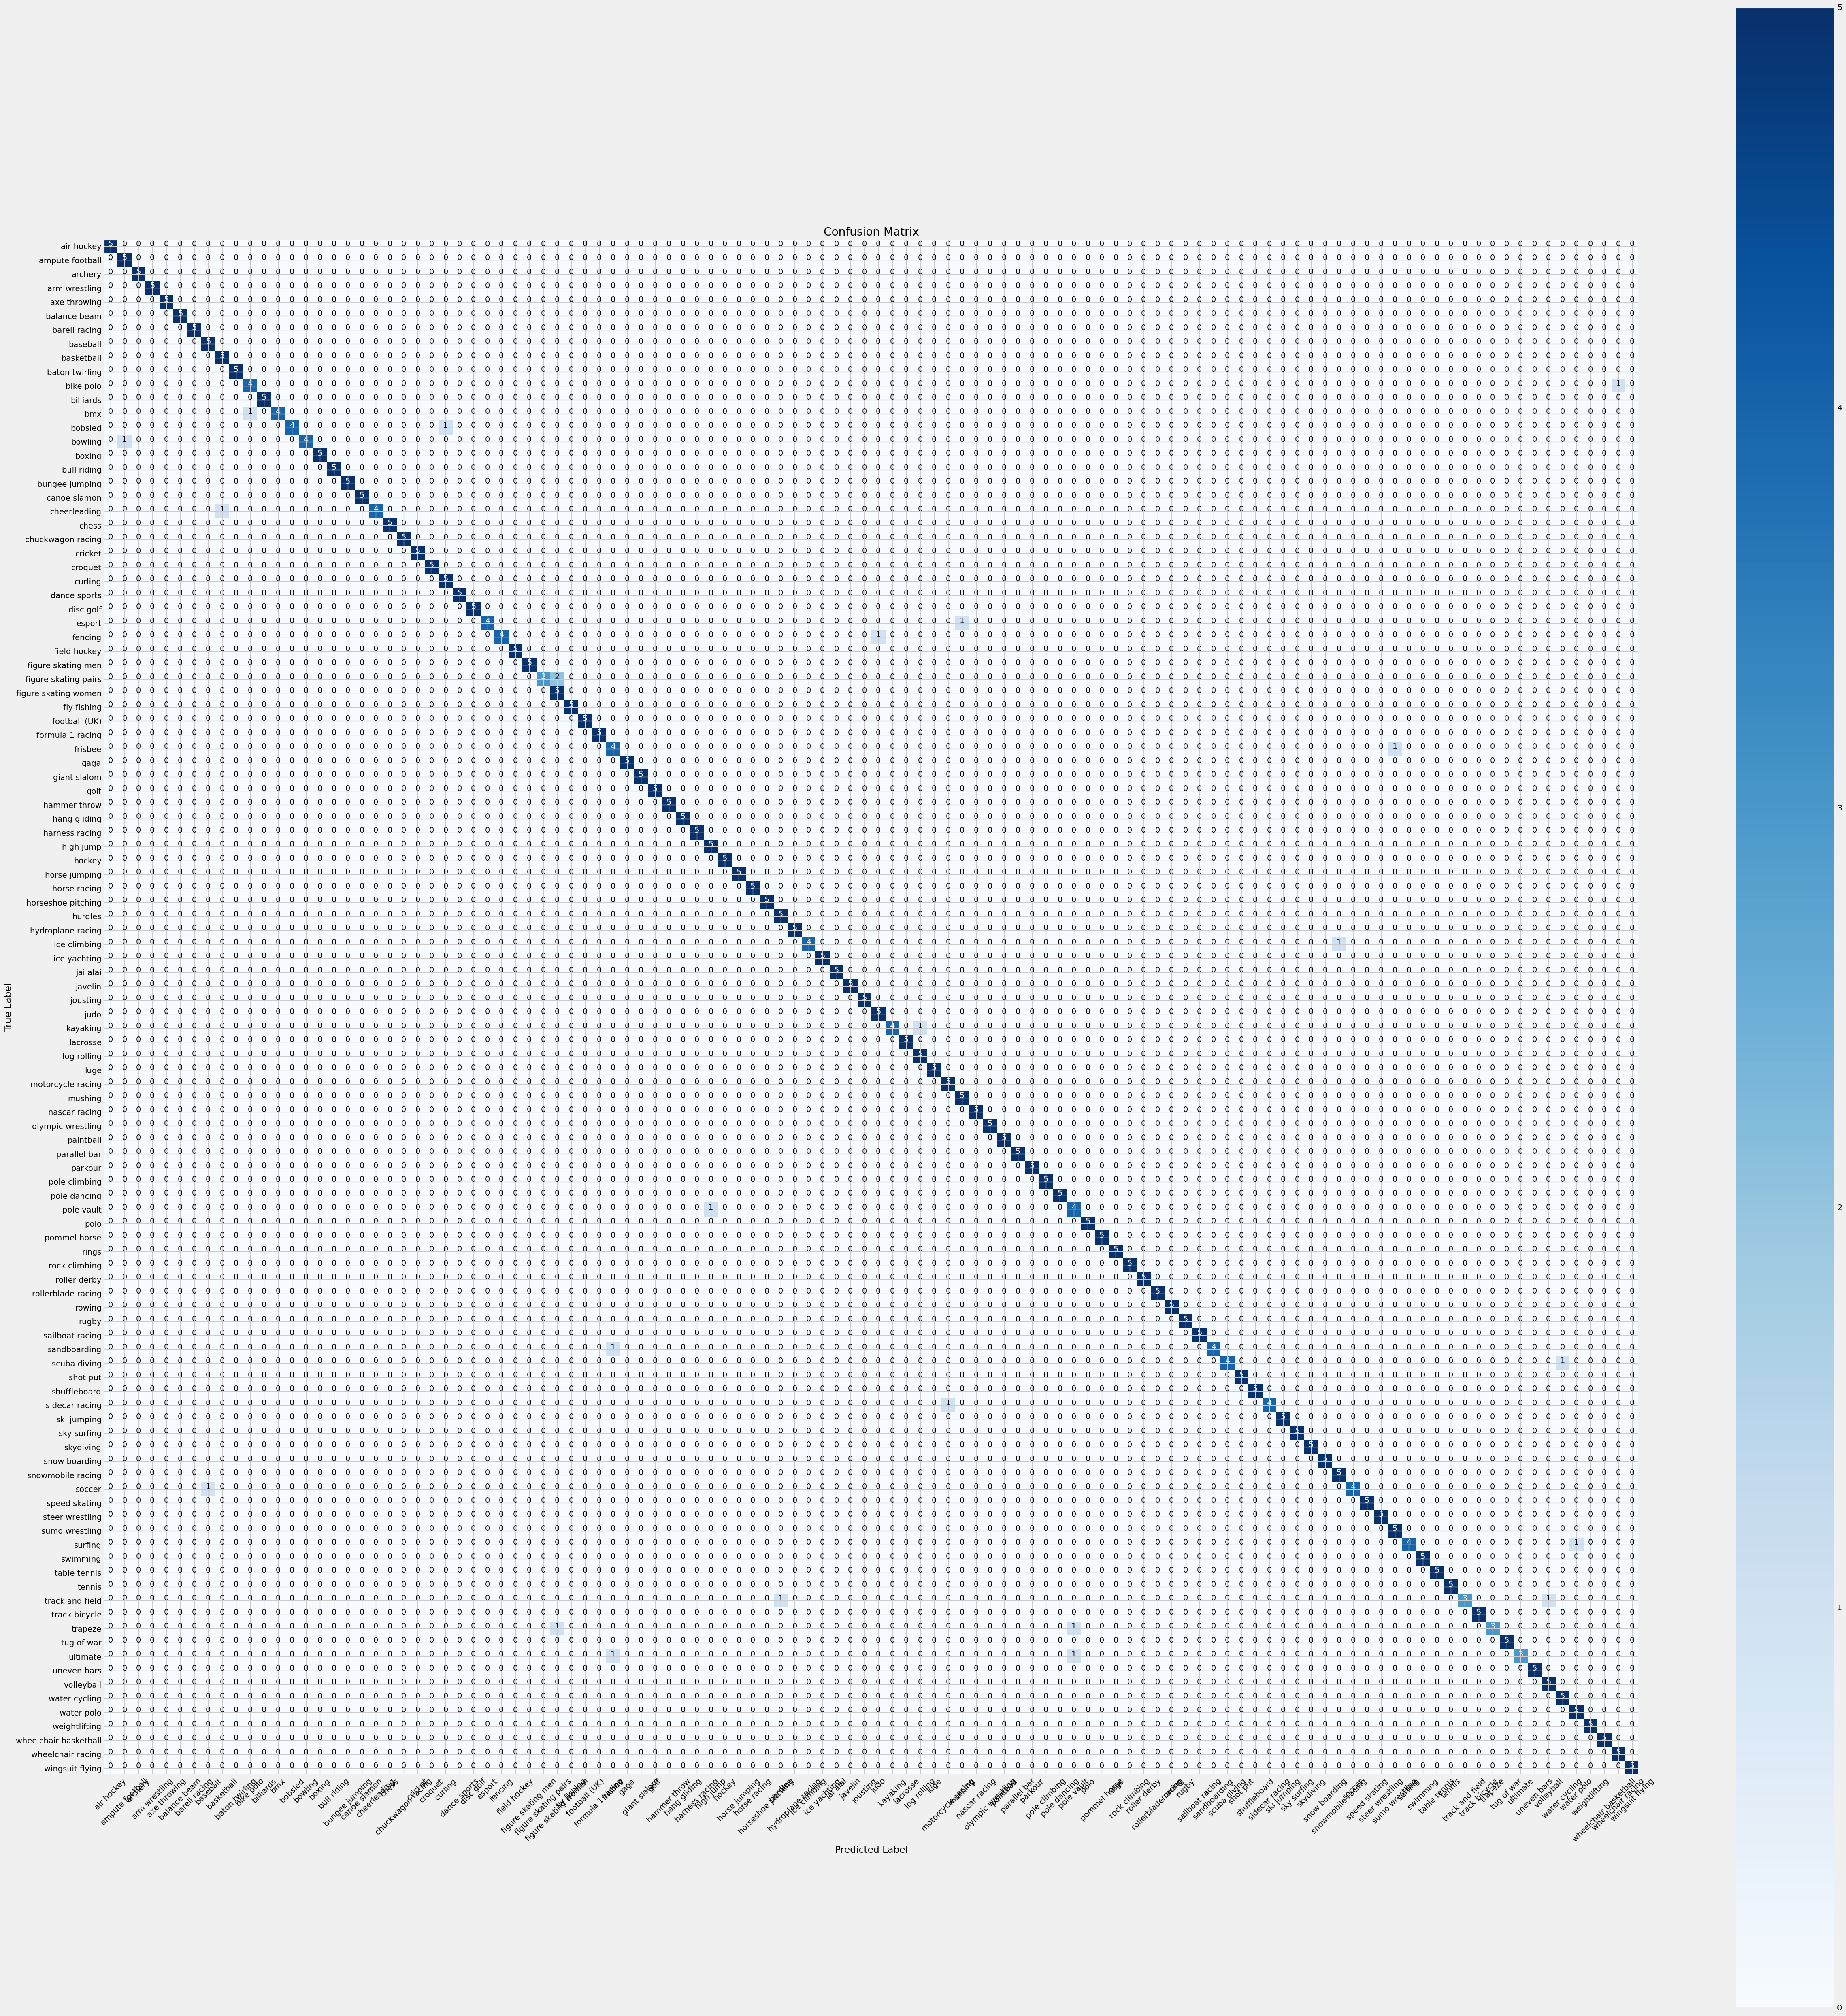

In [ ]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (50, 50))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()